In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal # for the Tukey window

# Problem 1

*Write a function that will shift an array by an arbitrary amount using a convolution. It should take 2 arguments: an array and an amount by which to shift the array. Plot a Gaussian that started in the centre of the array shifted by half the array length.*

In [2]:
def shift_conv(x, dx):
    """
    Parameters:
    x = array to shift
    dx = number of points to shift
    
    Returns:
    the shifted array
    """
    
    # FT the array
    xft = np.fft.fft(x)
    
    # k-modes
    k = np.arange(len(xft))
    
    # Shift by convolution
    ramp = np.exp(2*np.pi*1j*k*dx/len(x))
    xft_shift = xft*ramp
    
    # IFT
    x_shift = np.fft.ifft(xft_shift)
    
    return np.real(x_shift)

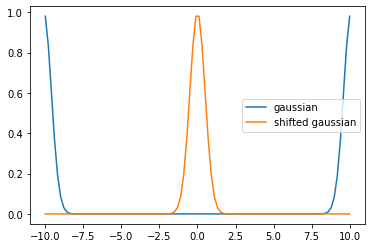

In [3]:
# plot the Gaussian, before and after the shift

# make the Gaussian
x = np.linspace(-10,10,100)
sigma = 0.5
gauss = np.exp(-0.5*x**2/sigma**2)

# shift so the gaussian starts in the center...?
gauss = np.fft.fftshift(gauss)

# shift by half the length
dx = len(x)/2
gauss_shift = shift_conv(gauss,dx)

# plot
plt.figure()
plt.plot(x, gauss, label='gaussian')
plt.plot(x, gauss_shift, label='shifted gaussian')
plt.legend()
plt.savefig('problem1_shift.png')

# Problem 2

## (a) 

*The correlation function $f * g = \int f(x) g(x+y) dx$. Through a similar proof, can show $f * g = \text{IFT}(\text{DFT}(f) * conj(\text{DFT}(g))$. Write a routine to take the correlation function of 2 arrays, plot the correlation function of a Gaussian with itself.*

In [4]:
def corr_fun(f1,f2):
    """
    Parameters:
    f1, f2 = two functions to correlate
    
    Returns:
    f2_f2 = correlation function
    """
    
    # DFT of both functions
    f1ft = np.fft.fft(f1)
    f2ft = np.fft.fft(f2)
    
    # Get correlation
    f1_f2 = np.fft.ifft(f1ft*np.conj(f2ft))
    
    return f1_f2

/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


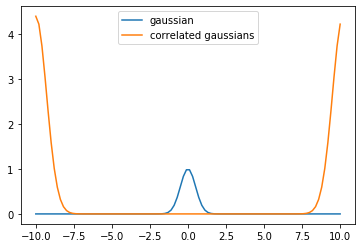

In [5]:
# make the Gaussian again
x = np.linspace(-10,10,100)
sigma = 0.5
gauss = np.exp(-0.5*x**2/sigma**2)

# correlate with itself
gauss_corr = corr_fun(gauss, gauss)

# plot
plt.figure()
plt.plot(x, gauss, label='gaussian')
plt.plot(x, gauss_corr, label='correlated gaussians')
plt.legend()
plt.savefig('problem2a_convolution.png')

## (b)

*Using these results, write a routine to take the correlation function of a Gaussian, shifted by an arbitrary amount, with itself. How does the correlation function depend on the shift? Does this surprise you?*

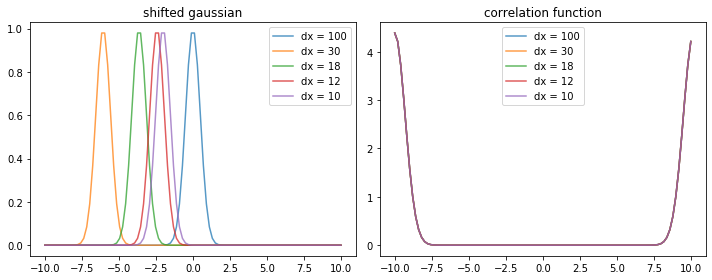

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4),tight_layout=True)

# loop over some (5) arbitrary shifts
div = np.linspace(1,10,5)
for i in range(len(div)):
    
    # take correlation of shifted Gaussian
    dx = int(len(gauss)/div[i])
    gauss_shift = shift_conv(gauss, dx)
    gauss_shift_corr = corr_fun(gauss_shift, gauss_shift)

    # plot
    ax1.plot(x, gauss_shift, alpha=0.75, label='dx = {}'.format(np.around(dx,3)))
    ax2.plot(x, gauss_shift_corr, alpha=0.75, label='dx = {}'.format(np.around(dx,3)))
    ax1.set_title('shifted gaussian')
    ax2.set_title('correlation function')
    
ax1.legend()
ax2.legend()
fig.savefig('problem2b_shift_convolve.png')

Fig: The correlation function looks the same, no matter what the shift is. 

# Problem 3

*The circulant (wrap-around) nature of the DFT can sometimes be problematic. Write a routine to take an FFT-based convolution of 2 arrays without any danger of wrapping around. You may wish to add zeros to the end of the input arrays.*

I'm not sure I understand the problem with wrapping around. Here I've tried to convolve 2 arrays with and without adding zeros to the ends of the arrays but the resulting convolution is the same.

The convolution of two functions is $f \otimes g = \int f(x) g(y-x) dx = \text{IFT}(\text{FT}(f) \text{FT}(g))$ 

In [7]:
def conv_2fun(f1,f2,pad=False):
    """
    f1, f2 = two functions to convolve
    pad = pad the ends of the arrays with zeros
    
    returns:
    convolution = convolution of f1 and f2
    """
    
    fun1 = f1
    fun2 = f2
    
    # Pad the input arrays with zeros
    if pad:
        f1_pad = np.zeros(len(f1)+10)
        f2_pad = np.zeros(len(f2)+10)
        f1_pad[5:-5] = f1
        f2_pad[5:-5] = f2
        
        fun1 = f1_pad
        fun2 = f2_pad
    
    # FT the two arrays
    f1ft = np.fft.fft(fun1)
    f2ft = np.fft.fft(fun2)
    
    # Get the convolution in real space
    convolution = np.fft.ifft(f1ft*f2ft)
    
    return convolution

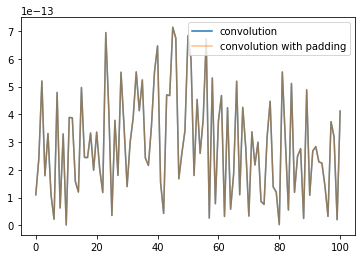

In [20]:
# make the arrays some noise and a sine wave?
x = np.arange(101)
f1 = np.sin(2*np.pi*x)
f2 = np.random.randn(len(x))
#f2 = gauss = np.exp(-0.5*(x-25)**2/5**2) # padding still doesn't change the convolution...

# get the convolution
conv = conv_2fun(f1,f2)

# plot
plt.figure()
plt.plot(np.abs(conv), label='convolution')

# convolve with padding
conv_pad = conv_2fun(f1, f2, pad=True)

# plot
plt.plot(np.abs(conv), alpha=0.5, label='convolution with padding')
plt.legend()
plt.savefig('problem3_convolution.png')

Fig: The convolution is the same with and without padding with zeros. I'm not understanding the wrap-around that we're trying to avoid.

# Problem 4

## (a)

*Show that $\sum_{x=0}^{N-1}\text{exp}(-2 \pi ikx/N) = \frac{1- \text{exp}(- 2 \pi i k)}{1 - \text{exp}(-2 \pi i k/N)}$. The sum can be re-written as $\sum \alpha^x$ where $\alpha = \text{exp}(-2 \pi ik/N)$ (sum of geometric series).*

Expand the sum:

$s_n = \sum_{x=0}^{N-1} = 1 + \alpha + \alpha^2 + ... + \alpha^{N-1}$

$\alpha s_n = \sum_{x=0}^{N-1} =  \alpha + \alpha^2 + ... + \alpha^{N}$

Subtract:

$s_n - \alpha s_n = \alpha - \alpha^N$

$s_n = \frac{1- \alpha^N}{1 - \alpha}$

Use $\alpha = \text{exp}(-2 \pi i k /N)$:

$s_n = \sum_{x=0}^{N-1} \text{exp}(-2 \pi i k /N) = \frac{1- (\text{exp}(-2 \pi i k /N))^N}{1 - \text{exp}(-2 \pi i k /N)} = \frac{1- \text{exp}(-2 \pi i k )}{1 - \text{exp}(-2 \pi i k /N)}$

## (b)

*Show that this approaches $N$ as $k$ approaches zero, and is zero for any integer $k$ that is not a multiple of $N$.*

As $k \rightarrow 0$ the sum $\frac{1- \text{exp}(-2 \pi i k )}{1 - \text{exp}(-2 \pi i k /N)} \rightarrow \frac{1-1}{1-1} = \frac{0}{0}$ so use L'Hopital:

$\frac{ \frac{d}{dk} (1- \text{exp}(-2 \pi i k ))}{\frac{d}{dk}(1 - \text{exp}(-2 \pi i k /N))} = \frac{(2 \pi i )\text{exp}(-2 \pi i k)}{(2 \pi i k)\text{exp}(2 \pi i k)/N} = N$

The denominator is non-zero for any $k$ that isn't a multiple of $N$, and the numerator is $1 - \text{exp}(-2 \pi i k) = 1 - cos(2 \pi k) + i sin(2 \pi k) = 1 - 1 + 0 = 0$

## (c)

*We can use this to analytically write down the DFT of a non-integer sine wave. Pick a non-integer value of $k$ and plot your analytic estimate of the DFT. Show that the FFT agrees (to within machine precision) with your analytic estimate. Are we close to a delta function?*

Take $sin(2 \pi xn/N) = \frac{\text{exp}(2 \pi i xn/N) - \text{exp}(-2 \pi i xn/N)}{2i} $, n is an integer.

The DFT of the sine wave is: 

$ \text{DFT}(sin(2 \pi xn/N)) =  \sum_{x=0}^{N-1}\frac{\text{exp}(2 \pi i xn/N) - \text{exp}(-2 \pi i xn/N)}{2i} \text{exp}(-2 \pi ikx/N) = \frac{1}{2i} \big( \sum_{x=0}^{N-1}\text{exp}(2 \pi i x(n-k)/N)  - \sum_{x=0}^{N-1}\text{exp}(-2 \pi i x(n+k)/N) \big)$

Rewrite the sums (same story as part a):

$ \text{DFT}(sin(2 \pi xn/N)) = \frac{1}{2i} \big( \frac{1- \text{exp}(- 2 \pi i (n-k))}{1 - \text{exp}(-2 \pi i (n-k)/N)} - \frac{1- \text{exp}(- 2 \pi i (n+k))}{1 - \text{exp}(-2 \pi i (n+k)/N)} \big) $

In [9]:
def sine_dft(x,n,k):
    """
    Parameters:
    x = x-values
    n = non-integer
    k = k-values
    
    Returns:
    yft = FFT of the sine wave
    yft_a = analytical DFT of the sine wave
    """
    
    # Get the sine wave
    N = len(x)
    y = np.sin(2*np.pi*x*n/N)
    
    # FFT
    yft = np.fft.fft(y)
    
    # Analytical DFT
    yft_a = np.zeros(N)
    
    for i in range(N):
        # When (n-k) = 0 the DFT = N
        if n-k[i]==0:
            yft_a[i]=N

        # Flag if (n-k) = a multiple of N
        elif (n-k[i])%N==0:
            print('zero denominator for k=', k[i])
            yft_a[i]=0
            
        # Flag if (n+k) = a multiple of N
        elif (n+k[i])%N==0:
            print('zero demoninator for k=', k[i])
        
        else:
            sum1 = (1 - np.exp(-2*np.pi*1j*(n-k[i]))) / (1 - np.exp(-2*np.pi*1j*(n-k[i])/N))
            sum2 = (1 - np.exp(-2*np.pi*1j*(n+k[i]))) / (1 - np.exp(-2*np.pi*1j*(n+k[i])/N))
            yft_a[i] = (1/2j)*(sum1 - sum2)

    return yft, yft_a

/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


The mean difference between the analytical FFT and DFT is 4.4788635537134995


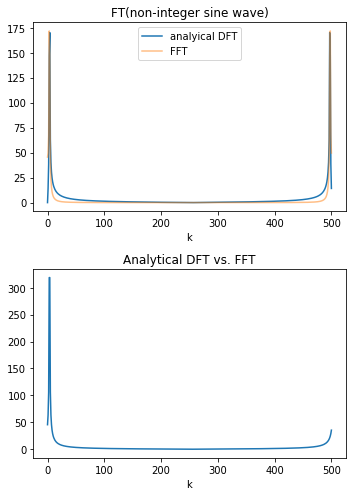

In [10]:
# say sampling rate works out so x and k are the same
N = 501
x = np.arange(N)
k = x
n = 3.5 

yft, yft_a = sine_dft(x,n,k)

# restrict?
lims = (x>=int(0.07*N))&(x<=int(0.92*N))
err_arr = np.real(np.abs(yft_a - yft))
err = np.mean(err_arr)
print('The mean difference between the analytical FFT and DFT is {}'.format(err))

# plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(5,7),tight_layout=True)
ax1.plot(k, np.abs(yft_a), label='analyical DFT')
ax1.plot(k, np.abs(yft), alpha=0.5, label='FFT')
ax1.legend()
ax1.set_title('FT(non-integer sine wave)')
ax1.set_xlabel('k')
ax2.plot(k, err_arr)
ax2.set_title('Analytical DFT vs. FFT')
ax2.set_xlabel('k')
fig.savefig('problem4c_dft_vs_fft.png')

Fig: I've done something wrong because these are not accurate to within machine precision.

## (d)

*Show that when we multiply by a window function: $0.5 - 0.5 \text{cos} (2 \pi x/N)$, the spectral leakage for a non-integer period sine wave drops dramatically.*

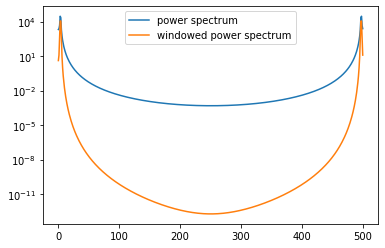

In [11]:
# sine wave
N = 501
x = np.arange(N)
k = x
n = 3.5 
sine = np.sin(2*np.pi*x*n/N)

# window function
win = 0.5*(1-np.cos(2*np.pi*x/N))

# FFTs
sineft = np.fft.fft(sine)
sineft_win = np.fft.fft(sine*win)

# plot
plt.figure()
plt.semilogy(k, np.abs(sineft)**2, label='power spectrum')
plt.semilogy(k, np.abs(sineft_win)**2, label='windowed power spectrum')
plt.legend()
plt.savefig('problem4d_window.png')

Fig: There's about 10 orders of magnitude less spectral leakage from windowing the signal.

## (e)

*Show that the Fourier transform of the window is $[N/2, - N/4, 0, ... 0 ,-N/4]$ (numerically or analytically). Use this to show that you can get the windowed Fourier transform by appropriate combinations of each point in the unwindowed Fourier transform and its immediate neighbors (careful with signs, some of the transforms need to be inverse FFTs).*

I know we need to use the windowed Fourier transform: $\text{FT}(fg) = F \otimes G \propto \int F(k) G(n-k) dk$ where $f$ and $g$ are the array we're transforming and the window. But I didn't get around to this part of the question :(

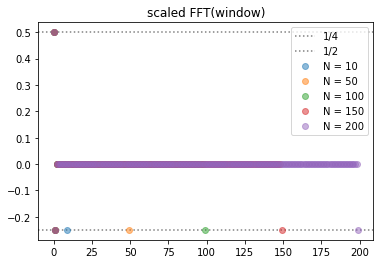

In [12]:
plt.figure()

# plot N/2 and -N/4 (but scaled so N=1)
plt.axhline(-0.25, ls=':', label='1/4', c='gray')
plt.axhline(0.5, ls=':', label='1/2', c='gray')

# loop through a few choices of N
Nall = [10,50,100,150,200]

for N in Nall:
    x = np.arange(N)
    k = x
    n = 3.5 
    sine = np.sin(2*np.pi*x*n/N)
    
    # window function
    win = 0.5*(1-np.cos(2*np.pi*x/N))
    winft = np.fft.fft(win)
    
    # scale the windowed FFT by N
    winft_scale = winft/N
    
    plt.plot(np.real(winft_scale), marker='o', ls='', alpha=0.5, label='N = {}'.format(N))
    
    # check indices
    #ind = N-1
    #print('FFT(win) = {} at k={}'.format(np.real(winft_scale[ind]), ind))
    
plt.title('scaled FFT(window)')
plt.legend()
plt.savefig('problem4e_numerical_FFTwin.png')

Fig: For all choices of N, the result is the same. At $k=0$ the FFT(window) is $N/2$, at $k=1$ and $k=N-1$ the FFT(window) is $-N/4$, and at all other values of $k$ the FFT(window) is $0$.

# Problem 5

Note: I made a class to do all the calculations for this problem, then I loop through the events to plot and print the results in the cells below. You can set the directory at the top of the next cell. The .npz files come from the output of "simple_read_ligo.py", these contain the data needed to run this notebook.

(a) *Come up with a noise model for the Livingston and Hanford detectors separately and describe how. Mention how you smooth the power spectrum and how you deal with lines. Explain how you window the data (might want a window that has an extended flat period near the center to avoid tapering the data/template where the signal is not small.*

Assume stationary noise, so we want to divide the Fourier transform of the strain by its smoothed power spectrum, then Fourier transform back. So this means $N^{-1}$ is the inverted power spectrum. I used one of Jon's functions to smooth the power spectrum (convolving with a Gaussian kernel in 1 dimension) and did some trial and error to find a $\sigma$. I also set $N^{-1}$ to be zero from frequencies outside 20 to 2000 Hz (the LIGO tutorial specifies that below 20 Hz the data isn't properly calibrated and 2000 Hz is just below the Nyquist frequency which gives the upper limit on detectable frequencies for these events).

I found that using a Blackman-Harris taper for one detector and a Tukey window for the other gave the most prominent spikes in the results of the matched filter, plus these choices didn't spread out the power too much and flattened some of the spikes.

(b) *Use this noise model to search the four sets of events using a matched filter. The mapping between data and templates can be found in "BBH_events_v2.json".*

The matched filter result comes from the right hand side of the linear least squares equation: $\text{RHS} = A^T N^{-1} d$. In this case, $\text{RHS}$ comes from taking the inverse Fourier transform of the noise-filtered template correlated with the data. (They're both windowed with a cosine function to take the Fourier transform). The noise-filtering is done by dividing the template by the noise model described above.

(c) *Estimate a noise for each event, and from the output of the matched filter, give a signal-to-noise ratio (SNR) for each event, both from the individual detectors and from the combined Livingston + Hanford events.*

The SNR is the absolute value of the result of the matched filter divided by $\sqrt{\text{LHS}}$, where $\text{LHS}$ is the sum of the correlation of the noise-filtered template signal with the template signal (both in Fourier space).

(d) *Compare the SNR you get from the scatter in the matched filter to the analytic SNR you expect from your noise model. How close are they, and if they disagree explain why.*

The analytical SNR is the height of the spike in the SNR described above. The SNR derived from scatter is the standard deviation of the matched filter result ($\text{RHS}$).

(e) *From the template and noise model, find the frequency from each event where half the weight comes from above that frequency and half below.*

Take the whitened template's power spectrum and integrate it along the frequencies. Then find the frequency where the integral is split in half.

(f) *How well can you localize the time of arrival (horizontal shift of the matched filter). The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainty you might expect given that the detectors are a few thousand km apart?*

The position of the gravitational wave event is $\Delta l = c \Delta t$, where $c$ is the speed of light and $\Delta t$ is the difference in arrival times for the two detectors which is given by the time difference for the matched filter results (the spikes' locations). I think the analytical uncertainty in the matched filter result is $\frac{1}{\sqrt{\text{LHS}}}$. But I think we run into the same problems using this as part (d) (there might be normalization errors or incomplete/incorrect assumptions about the noise when making the noise model) so I'm using the scatter in the matched filter ($\sigma$) as the uncertainty in time. So the error in position from taking the difference between the two detectors is $c \sqrt{\sigma_{\text{Hanford}}^2 + \sigma_{\text{Livingston}}^2}$.

In [13]:
# set the directory here
#directory='./'
directory='../../../../Phys 641 - Astro/PHYS641/Assignment_4/'

# Jon's function for smoothing the power spectrum
def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

# Class for doing all Problem 5 parts
class mf_ligo:
    
    def __init__(self, data_num, dat_path=directory):

        # Name the files and GW events
        if data_num == 1:
            fname_L = 'L-L1_LOSC_4_V2-1126259446-32.npz'
            fname_H = 'H-H1_LOSC_4_V2-1126259446-32.npz'
            fname_t = 'GW150914_4_template.npz'
            self.gw_name = "GW150914"
        elif data_num == 2:
            fname_L = 'L-L1_LOSC_4_V2-1128678884-32.npz'
            fname_H = 'H-H1_LOSC_4_V2-1128678884-32.npz'
            fname_t = 'LVT151012_4_template.npz'
            self.gw_name = "LVT151012"
        elif data_num == 3:
            fname_L = 'L-L1_LOSC_4_V2-1135136334-32.npz'
            fname_H = 'H-H1_LOSC_4_V2-1135136334-32.npz'
            fname_t = 'GW151226_4_template.npz'
            self.gw_name = "GW151226"
        elif data_num == 4:
            fname_L = 'L-L1_LOSC_4_V1-1167559920-32.npz'
            fname_H = 'H-H1_LOSC_4_V1-1167559920-32.npz'
            fname_t = 'GW170104_4_template.npz'
            self.gw_name = "GW170104"

        # Data names given by detectors
        self.data_names = ['Livingston', 'Hanford']

        # All the arrays and values I want to save
        self.strains, self.tp, self.time, self.nu, self.nu0 = [],[],[],[],[]
        self.strain_pspec, self.win_pspec, self.smooth_pspec = [],[],[]
        self.RHS, self.SNR, self.SNR_analytical, self.SNR_scatter, self.half_nus = [],[],[],[],[]
        self.loc_event, self.event_err = [],[]

        for datas in ['Livingston', 'Hanford']:

            if datas=='Livingston':
                dat = np.load(dat_path+fname_L, allow_pickle=True)
                strain = dat['strain']
                win = np.blackman(len(strain))
                # Windows that did not look good:
                #win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(strain)))
                #win = signal.tukey(len(strain), alpha=1.0/8) # amps were super small from this one
            elif datas=='Hanford':
                dat = np.load(dat_path+fname_H, allow_pickle=True)
                strain = dat['strain']
                # Windows that did not look good:
                #win = np.blackman(len(strain)) # amps were super small from this one
                #win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(strain)))
                # try scipy tukey?
                win = signal.tukey(len(strain), alpha=1.0/8)

            # Append the raw data
            self.strains.append(strain)

            # Load template
            gw_dat = np.load(dat_path+fname_t, allow_pickle=True)
            self.tp, tx = gw_dat['tp'], gw_dat['tx']

            # Get the times and total observation time
            dt = dat['dt']
            time = dt*np.arange(len(strain))
            self.time.append(time)
            utc = dat['utc']
            t_tot = dt*len(strain)
            
            # Save the power spectrum (un-windowed, un-smoothed)
            strain_ft_raw = np.fft.fft(strain)
            self.strain_pspec.append(np.abs(strain_ft_raw)**2)
            
            # Make frequencies for the raw fft
            nu0 = np.arange(len(strain_ft_raw))/t_tot
            self.nu0.append(nu0)

            # FFT the windowed strain
            strain_ft = np.fft.fft(win*strain)

            # Save the windowed power specrtum
            self.win_pspec.append(np.abs(strain_ft)**2)
        
            # Trial and error to find a nice sigma to smooth
            strain_smooth = smooth_vector(np.abs(strain_ft)**2,sig=10)
            strain_smooth = strain_smooth[:len(strain_ft)//2+1]

            # Save the smoothed power spectrum
            self.smooth_pspec.append(strain_smooth)
            
            # Make Ninv using the smoothed spectrum
            Ninv = 1/strain_smooth

            # Make the frequencies: k=i corresponds to nu=i/(total observation time)
            nu = np.arange(len(strain_smooth))/t_tot
            self.nu.append(nu)

            # Zero the frequencies we don't care about (>20 Hz, <2000 Hz)
            Ninv[nu<20] = 0
            Ninv[nu>2000] = 0

            # Whiten the model/template by the noise
            # I'm not sure, but do I need a new window? (blackman gave infinite SNRs...)
            win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(self.tp)))
            
            # Normalization for window and Fourier transforms
            win_norm = 1/np.sqrt(np.mean(win**2))
            ft_norm = 1/np.sqrt(len(self.tp))
            
            # Fourier transform the windowed template and filter it
            template_ft = np.fft.rfft(self.tp*win) *win_norm*ft_norm # normed now
            template_filt = template_ft*Ninv 
            
            # Fourier tranform windowed data
            data_ft = np.fft.rfft(strain*win) *win_norm*ft_norm # normed now

            # Get inverse Fourier transform normalization
            ift_norm = len(data_ft)
            
            # Matched filter is the correlation
            rhs = np.fft.irfft(data_ft*np.conj(template_filt)) *ift_norm # normed now
            self.RHS.append(rhs)

            # Get the SNR (analytical)
            scale_SNR = np.sum(template_ft*np.conj(template_filt))
            SNR = np.abs(rhs)/np.sqrt(np.abs(scale_SNR))
            self.SNR.append(SNR)
            self.SNR_analytical.append(np.max(SNR))
            
            # Get the SNR (from the scatter)
            SNR_scatter = np.std(rhs)
            self.SNR_scatter.append(SNR_scatter)

            # Find the frequency where half the weight is above and half below.
            # I'm repeating the above process, but using whitening - meaning
            # taking the square root of N^-1

            # Whiten the template
            ninv = np.sqrt(Ninv)
            template_ft = np.fft.rfft(self.tp*win) *win_norm*ft_norm # normed now
            template_wh = template_ft*ninv

            # Integrate along frequencies
            template_pspec = np.abs(template_wh)**2
            integral=np.cumsum(template_pspec*(nu[1]-nu[0]))

            # Halve the weight
            half_weight = integral[-1]/2

            # Find frequency where this happens
            mask_weight = integral <= half_weight
            half_nu = nu[mask_weight][-1]
            self.half_nus.append(half_nu)
            
            # Time of the event from the matched filter
            t_event = time[np.argmax(SNR)]
            
            # Convert to spatial location (in km)
            c = 3e5
            self.loc_event.append(t_event*c)
            
            # Uncertainty in position
            event_err = c*SNR_scatter
            self.event_err.append(event_err)

Initialize the class for each event.

In [14]:
LIGO = []

for i in range(4):
    
    # get the ligo object
    ligo_i = mf_ligo(data_num=i+1)
    
    # append it
    LIGO.append(ligo_i)

Plot the data, raw strain power spectrum, windowed power spectrum, and smoothed power spectrum (for each event).

/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


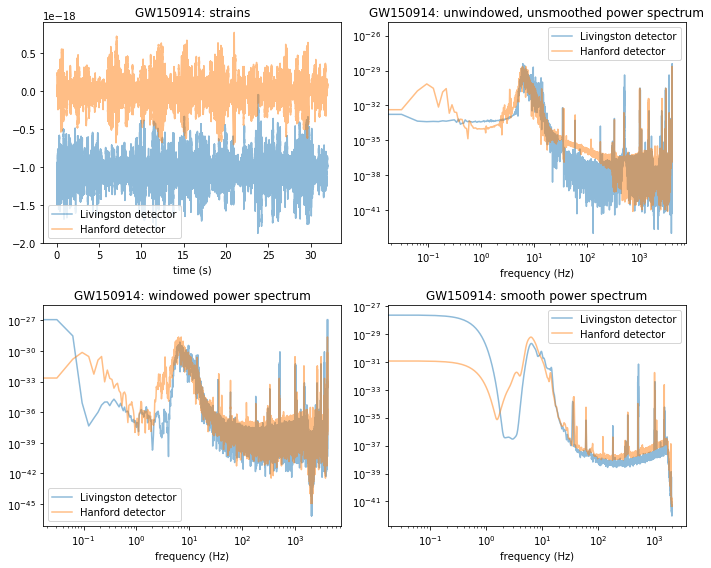

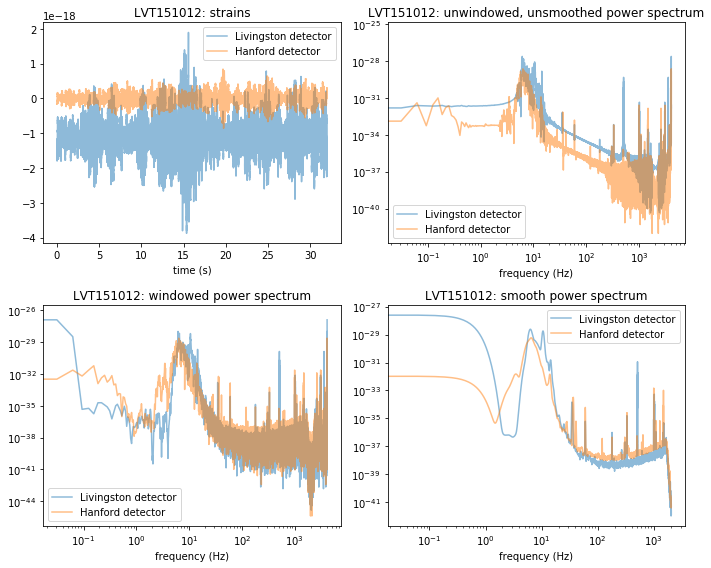

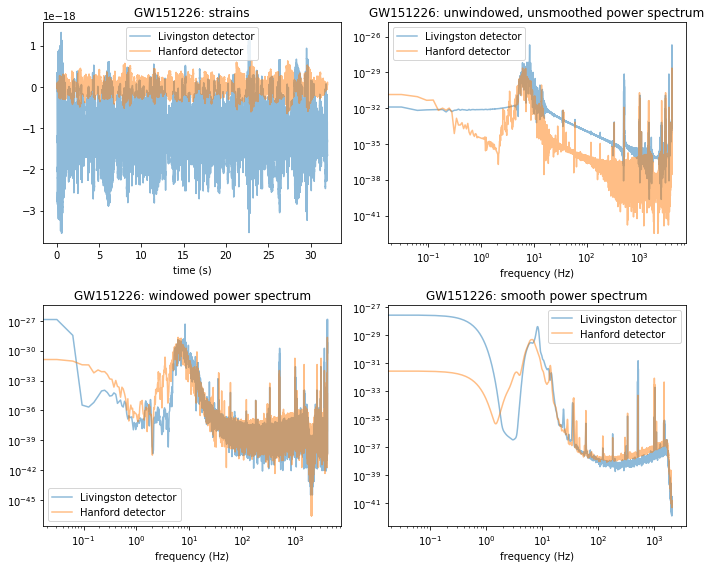

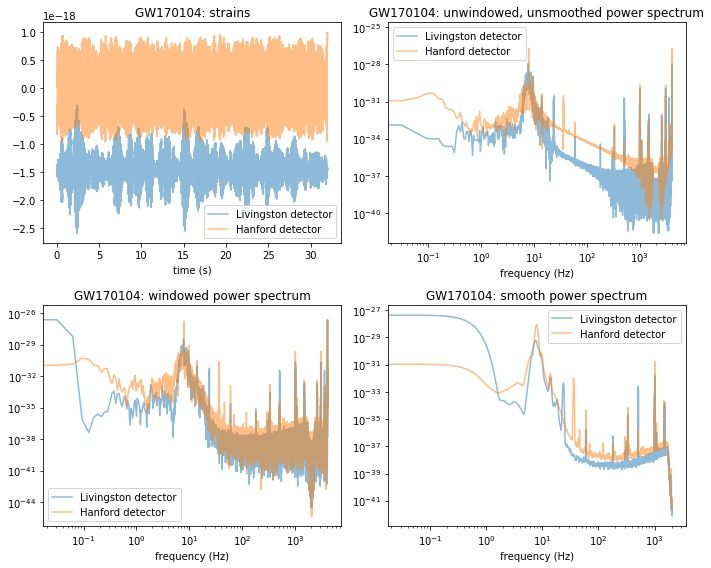

In [15]:
# 4 plots for each event
for i in range(4):
    
    # get the relevant things to plot
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    strains = ligo.strains
    time = ligo.time
    nu = ligo.nu
    nu0 = ligo.nu0
    strain_pspec = ligo.strain_pspec
    win_pspec = ligo.win_pspec
    smooth_pspec = ligo.smooth_pspec
    data_names = ligo.data_names
    
    # put into arrays to loop through spectra
    specs_arr = [strains, strain_pspec, win_pspec, smooth_pspec]
    specs_labels = ['strains', 'unwindowed, unsmoothed power spectrum', 
                   'windowed power spectrum', 'smooth power spectrum']
    x_arr = [time, nu0, nu0, nu]
    x_labels = ['time (s)', 'frequency (Hz)', 'frequency (Hz)', 'frequency (Hz)']
    det_names = 4*[data_names]

    # 4 plots for each type of spectrum
    fig, axs = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
    axs = axs.ravel()
    for j in range(4):
        
        # plot for both detectors
        if j==0:
            axs[j].plot(x_arr[j][0], specs_arr[j][0], alpha=0.5, label='{} detector'.format(det_names[j][0]))
            axs[j].plot(x_arr[j][1], specs_arr[j][1], alpha=0.5, label='{} detector'.format(det_names[j][1]))
        else: 
            axs[j].loglog(x_arr[j][0], specs_arr[j][0], alpha=0.5, label='{} detector'.format(det_names[j][0]))
            axs[j].loglog(x_arr[j][1], specs_arr[j][1], alpha=0.5, label='{} detector'.format(det_names[j][1]))
        axs[j].set_xlabel(x_labels[j])
        axs[j].set_title('{}: {}'.format(gw_name, specs_labels[j]))
        axs[j].legend()
    fig.savefig('problem5a_{}_noisemodel.png'.format(gw_name))

Plot the matched filter results:

/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


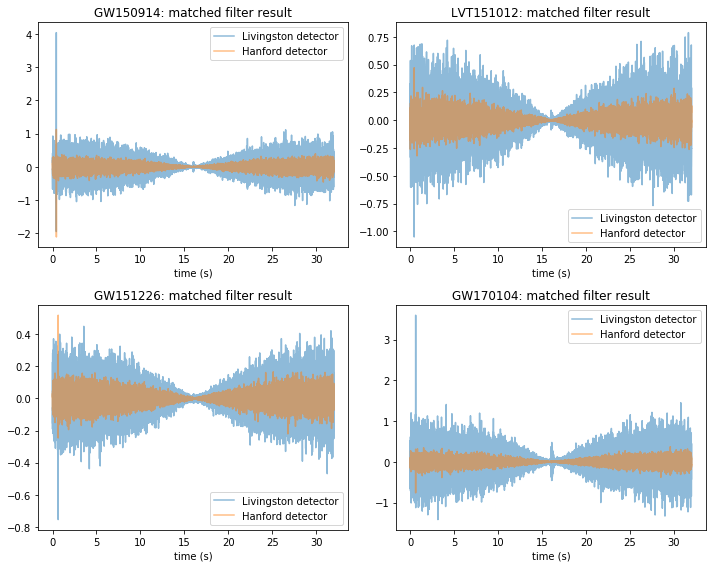

In [16]:
fig, axs = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
axs = axs.ravel()

# 4 plots for each event
for i in range(4):
    
    # get the relevant things to plot
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    time = ligo.time
    data_names = ligo.data_names
    rhs = ligo.RHS
    
    # plot both detectors
    axs[i].plot(time[0], rhs[0], alpha=0.5, label='{} detector'.format(data_names[0]))
    axs[i].plot(time[1], rhs[1], alpha=0.5, label='{} detector'.format(data_names[1]))
    axs[i].set_xlabel('time (s)')
    axs[i].set_title('{}: matched filter result'.format(gw_name))
    axs[i].legend()
fig.savefig('problem5b_matchedfilter.png')

Fig: Both the detectors for LVT151012 are giving the worst result of the four events (good results being a very statistically significant spike indicating where in time the matched filter thinks the template can be found in the data).

Plot the SNR results and print one number for each:

Event: GW150914
Livingston SNR from scatter = 0.2309 and analytical = 0.0616
Hanford SNR from scatter = 0.085 and analytical = 0.0499
detector-averaged SNR from scatter = 0.158 and analytical = 0.0558

Event: LVT151012
Livingston SNR from scatter = 0.156 and analytical = 0.0234
Hanford SNR from scatter = 0.0548 and analytical = 0.0171
detector-averaged SNR from scatter = 0.1054 and analytical = 0.0202

Event: GW151226
Livingston SNR from scatter = 0.0834 and analytical = 0.0315
Hanford SNR from scatter = 0.0374 and analytical = 0.0274
detector-averaged SNR from scatter = 0.0604 and analytical = 0.0295

Event: GW170104
Livingston SNR from scatter = 0.28 and analytical = 0.0453
Hanford SNR from scatter = 0.0679 and analytical = 0.0221
detector-averaged SNR from scatter = 0.174 and analytical = 0.0337



/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


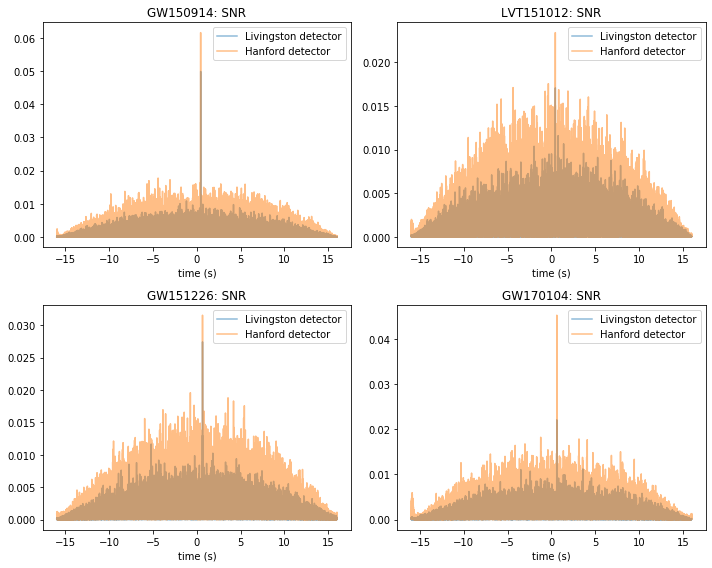

In [22]:
fig, axs = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
axs = axs.ravel()

# 4 plots for each event
for i in range(4):
    
    # get the relevant things to plot
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    time = ligo.time
    data_names = ligo.data_names
    SNR = ligo.SNR
    SNR_analytical = ligo.SNR_analytical
    SNR_scatter = ligo.SNR_scatter
    
    # shift the SNR
    SNR = np.fft.fftshift(SNR)
    
    # get the average SNRs for the two detectors
    SNR_scatter_avg = np.mean(SNR_scatter)
    SNR_analytical_avg = np.mean(SNR_analytical)
    
    # print SNR for both detectors
    print('Event: {}'.format(gw_name))
    print('{} SNR from scatter = {} and analytical = {}'.format(data_names[0], 
                                                                np.around(SNR_scatter[0],4), 
                                                                np.around(SNR_analytical[0],4)))
    print('{} SNR from scatter = {} and analytical = {}'.format(data_names[1], 
                                                                np.around(SNR_scatter[1],4), 
                                                                np.around(SNR_analytical[1],4)))
    print('detector-averaged SNR from scatter = {} and analytical = {}\n'.format(np.around(SNR_scatter_avg,4), 
                                                                              np.around(SNR_analytical_avg,4)))
    
    
    # plot both detectors
    axs[i].plot(time[0] - time[0][-1]/2, SNR[0], alpha=0.5, label='{} detector'.format(data_names[0]))
    axs[i].plot(time[1] - time[1][-1]/2, SNR[1], alpha=0.5, label='{} detector'.format(data_names[1]))
    axs[i].set_xlabel('time (s)')
    axs[i].set_title('{}: SNR'.format(gw_name))
    axs[i].legend()
fig.savefig('problem5c_SNR.png')

Fig: Comparing the y axes of this against the LIGO tutorial, I know there's a mistake in calculating the SNRs.

SNR comments: I think my analytical and scatter-derived SNRs are off for a couple reasons. For one, I could have my normalizations wrong: I had to normalize because of the window function, which is used on both the template and the data, and the Fourier plus inverse Fourier transforms, so there are many oportunities to get that wrong. Secondly, I think the analytic SNRs would match the scatter if we could say with certainty that we trust the noise model, which here could have coding errors as well as errors from assuming the noise is stationary.

Print the frequencies where half the weight is above and half below:

In [23]:
# loop through evens
for i in range(4):
    
    # load the frequencies
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    data_names = ligo.data_names
    half_nu = ligo.half_nus

    # print the results for both detectors
    print('event: {}'.format(gw_name))
    print('{} detector: half weight at frequency {}'.format(data_names[0], half_nu[0]))
    print('{} detector: half weight at frequency {}\n'.format(data_names[1], half_nu[1]))

event: GW150914
Livingston detector: half weight at frequency 117.28125
Hanford detector: half weight at frequency 105.09375

event: LVT151012
Livingston detector: half weight at frequency 98.3125
Hanford detector: half weight at frequency 81.6875

event: GW151226
Livingston detector: half weight at frequency 108.1875
Hanford detector: half weight at frequency 80.34375

event: GW170104
Livingston detector: half weight at frequency 76.09375
Hanford detector: half weight at frequency 98.0



Should these agree with each other more?

Print the positions of the GW events with uncertainties:

In [19]:
# loop through evens
for i in range(4):
    
    # load the frequencies
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    loc_event = ligo.loc_event
    event_err = ligo.event_err
    
    # take the difference
    loc = loc_event[1] - loc_event[0]
    err = np.sqrt(event_err[0]**2 + event_err[1]**2)

    # print the results for both detectors
    print('Event {} has position = {} +/- {} km'.format(gw_name,loc, err))

Event GW150914 has position = 2197.265625 +/- 73821.77177342745 km
Event LVT151012 has position = -73.2421875 +/- 49602.533512980146 km
Event GW151226 has position = 366.2109375 +/- 27427.08734346364 km
Event GW170104 has position = -952.1484375 +/- 86439.96069583285 km


This uncertainty seems too large, but the uncertainty from using $\text{LHS}$ from the matched filter result was ~ $10^{-7}$ which is more wrong I think, especially given the detectors are a few thousand km apart.